# CISC 867 - Assignment 2

## Question 1

In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import random
from sklearn.datasets import fetch_openml
from sklearn.model_selection import KFold
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import check_random_state
%matplotlib inline

In [2]:
class Network:
    "Creates the architecture for a simple neural network with one hidden layer"

    def __init__(self, X, y, X_val=None, y_val=None, early_stopping=False, h_size=5,
                 input_size=2, output_size=1, class_size=2):
        """        
        Parameters
        ===========
        X : ndarray
            The training data.
        y : ndarray
            The testing data.
        X_val : ndarray
            The validation training data, if provided.
        y_val : ndarray
            The validation testing data, if provided.
        early_stopping : True/False
            Used if want to stop the training when the validation error
            crosses the training error        
        h_size : integer
            The number of neurons in the hidden layer. Defaults to 5
        input_size : integer
            The number of neurons in the input layer. Defaults to 2
        output_size : integer
            The number of neurons in the output layer. Defaults to 1
        class_size : integer
            The number of classes in the data-set
        """
        self.input_size = X.shape[0]
        self.hidden_size = h_size
        self.output_size = output_size
        self.class_size = class_size
        self.X = X
        self.y = y
        self.X_val = X_val
        self.y_val = y_val
        self.early_stopping = early_stopping

        # Set weights and biases
        # From numpy documentation: sigma * np.random.randn(...) + mu
        self.w1 = np.random.randn(self.hidden_size, self.input_size)
        self.b1 = np.zeros((self.hidden_size, 1))
        self.w2 = np.random.randn(self.class_size, self.hidden_size)
        self.b2 = np.zeros((self.class_size, 1))
        

    # Sigmoid function
    def sigmoid(self, z):
        return 1.0 / (1.0 + np.exp(-z))
    
    # Cross-entropy (log loss) cost function
    def log_loss(self, y, y_hat):   
        m = y.shape[1]
        L = -(1/m) * np.sum(np.multiply(y, np.log(y_hat)))
        return L

    # Forward propagation function
    def forward(self, X):
        # hidden layer 
        a1 = np.matmul(self.w1, X) + self.b1
        h1 = self.sigmoid(a1)
        
        # output layer
        a2 = np.matmul(self.w2, h1) + self.b2
        h2 = np.exp(a2) / np.sum(np.exp(a2), axis=0)
        
        return a1, h1, a2, h2

    def train(self, learn_rate=0.5, epochs=1000):
        """Trains the neural network.
        
        Parameters
        ===========
        learn_rate : float
            The learning rate for the neural network. Defaults to 0.5
        epochs : integer
            The number of epochs to do training over. Defaults to 1000
        """
        # Initialize the parameters
        self.learn_rate = learn_rate
        self.epochs = epochs
        m = self.y.shape[1]

        self.cost_list = []  # store the costs so they can be plotted
        self.cost_val_list = [] # store the cost for the validation set
        
        print("Training...")
        
        # Run through each of the epochs
        epoch_counter = self.epochs/10
        for epoch in range(self.epochs):

            a1, h1, a2, h2 = self.forward(self.X)
            
            cost = self.log_loss(self.y, h2)
            

            da2 = h2-self.y
            dw2 = (1./m) * np.matmul(da2, h1.T)
            db2 = (1./m) * np.sum(da2, axis=1, keepdims=True)

            dh1 = np.matmul(self.w2.T, da2)
            da1 = dh1 * self.sigmoid(a1) * (1 - self.sigmoid(a1))
            dw1 = (1./m) * np.matmul(da1, self.X.T)
            db1 = (1./m) * np.sum(da1, axis=1, keepdims=True)

            self.w2 = self.w2 - learn_rate * dw2
            self.b2 = self.b2 - learn_rate * db2
            self.w1 = self.w1 - learn_rate * dw1
            self.b1 = self.b1 - learn_rate * db1

            self.cost_list.append(cost)
            
            # if we are using validation set, store the validation cost
            if self.X_val is not None:
                a1, h1, a2, h2 = self.forward(self.X_val)
                val_cost = self.log_loss(self.y_val, h2)
                self.cost_val_list.append(val_cost)
                
                if self.early_stopping is True:
                    if val_cost > cost:
                        print("Val cost greater than train cost. Training finished")
                        break            

            if (epoch % epoch_counter == 0):
                if self.X_val is not None:
                    print("Epoch", epoch,"\t", " Train cost: %0.7f" %cost,
                          "\tVal cost: %0.7f" %val_cost)
                else:
                    print("Epoch", epoch, " train cost: ", cost)

        print("Epoch", epoch,"\t", " Train cost: %0.7f" %cost)
        print("Training finished")
        
    def loss_chart(self):
        """Plot the log loss over each epoch"""
        fig, ax = plt.subplots()
        ax.semilogy(self.cost_list)

        ax.set(
            xlabel="Epochs", ylabel="Log Loss (log scale)", 
            title="Log Loss vs. Number of Epochs"
        )
        
        if self.X_val is not None:
            ax.semilogy(self.cost_val_list)
            ax.legend(('Train Cost','Validation Cost'))

        return plt
        
    def predict(self, X, y):
        "Function to predict the results after network has been trained"
    
        a1, h1, a2, h2 = self.forward(X)
        predictions = np.argmax(h2, axis=0)
        labels = np.argmax(y, axis=0)
        
        print("\nConfusion Matrix:")
        print(confusion_matrix(predictions, labels))
        print("\nClassification Report:\n")
        print(classification_report(predictions, labels))

Let's test the above Network class on a multi-class XOR problem:

Training...
Epoch 0 	  Train cost: 1.7776735 	Val cost: 0.9223157
Epoch 10000 	  Train cost: 0.0002823 	Val cost: 0.0003103
Epoch 20000 	  Train cost: 0.0001316 	Val cost: 0.0001445
Epoch 30000 	  Train cost: 0.0000846 	Val cost: 0.0000929
Epoch 40000 	  Train cost: 0.0000620 	Val cost: 0.0000680
Epoch 50000 	  Train cost: 0.0000488 	Val cost: 0.0000534
Epoch 60000 	  Train cost: 0.0000401 	Val cost: 0.0000439
Epoch 70000 	  Train cost: 0.0000340 	Val cost: 0.0000372
Epoch 80000 	  Train cost: 0.0000295 	Val cost: 0.0000323
Epoch 90000 	  Train cost: 0.0000260 	Val cost: 0.0000284
Epoch 99999 	  Train cost: 0.0000232
Training finished


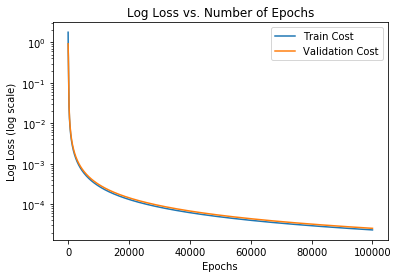


Confusion Matrix:
[[2 0]
 [0 2]]

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2

   micro avg       1.00      1.00      1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4



In [3]:
# Set seed so that results can be replicated
np.random.seed(seed=12)

# Training and testing data
X_train = np.array([[1,1], [0,1], [1,0], [0,0], [1,1]], dtype=float).T
y_train = np.array([[1, 0, 0, 1,1],[0,1,1,0,0]], dtype=float)

X_test = np.array([[1,1], [0,1], [1,0], [0,0]], dtype=float).T
y_test = np.array([[1, 0, 0, 1],[0,1,1,0]], dtype=float)

# Train and test the network on multi-class XOR
nn1 = Network(X=X_train, y=y_train, X_val=X_test, early_stopping=False, y_val=y_test, h_size=10)
nn1.train(learn_rate=0.9, epochs=100000)
nn1.loss_chart().show()
nn1.predict(X=X_test,y=y_test)

Looks like it trained well and is getting the expected results!

## Question 2

Load the MNIST data set from open_ml (can also load the pickle if available). We will then split the data into 10 equal folds, and then create a training, validation, and test set. 

In [4]:
# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

# Store data into a pickle for easy access
# data = fetch_openml('mnist_784', version=1, return_X_y=True)
# pickle.dump(data, open("data.p","wb"))

# Load data from pickle
# X, y = pickle.load(open("data.p","rb"))

# example for random split here: https://bit.ly/2ShYHvw
random_state = check_random_state(5)
permutation = random_state.permutation(X.shape[0])

n_splits = 10 # number of splits
len_splits = int(X.shape[0]/n_splits)
split_list = [] # store the permutations for the splits

# Create splits from the permutation
for s in range(n_splits):
    split_list.append(permutation[s*len_splits:(s+1)*len_splits])
    print("Samples in fold %i:" %(s+1),len(permutation[s*len_splits:(s+1)*len_splits]) )

# create training permutation
train_perm = split_list[0] 
for s in range(n_splits-3):    
    train_perm = np.concatenate((train_perm,split_list[s+1]),axis=None)
print("Samples in train_perm:",len(train_perm))
    
# create validation permutation
val_perm = split_list[n_splits-2:n_splits-1][0]
print("Samples in val_perm:",len(val_perm))

# create test permutation
test_perm = split_list[n_splits-1:n_splits][0]
print("Samples in test_perm:",len(test_perm))

Samples in fold 1: 7000
Samples in fold 2: 7000
Samples in fold 3: 7000
Samples in fold 4: 7000
Samples in fold 5: 7000
Samples in fold 6: 7000
Samples in fold 7: 7000
Samples in fold 8: 7000
Samples in fold 9: 7000
Samples in fold 10: 7000
Samples in train_perm: 56000
Samples in val_perm: 7000
Samples in test_perm: 7000


Next, we will see how many digits are in each fold by plotting them.

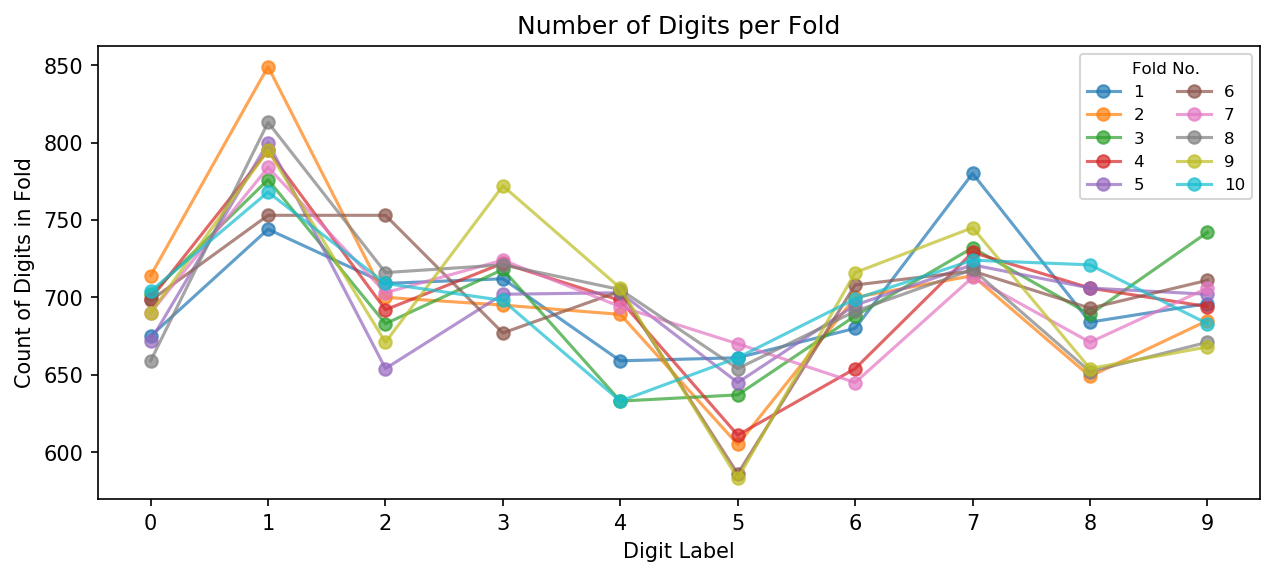

In [5]:
fig, ax = plt.subplots(figsize=(10,4),dpi=150)
ax.set(xlabel='Digit Label', ylabel='Count of Digits in Fold',
       title='Number of Digits per Fold')

for i in range(10):
    df = pd.DataFrame(y[split_list[i]],columns=['Digit'])
    plt.plot(df['Digit'].value_counts().sort_index(), 'o-', alpha=0.7)


plt.legend(('1','2','3','4','5','6','7','8','9','10'),fontsize=8,
           title='Fold No.', title_fontsize=8, ncol=2)
plt.show()

It looks like all the folds have roughly the same amount of digits (appears random enough). It should be noted, that in the data-set, digit '5' has the least digits. <br/>

Now we will create the training, validation, and test sets.

X_train shape: (784, 56000)
y_train shape before one-hot vector: (56000,)
y_train shape after one-hot vector: (10, 56000)


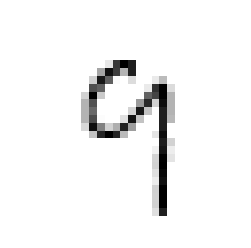

one-hot vecotr: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
9


In [6]:
# Create training set
X_train = X[train_perm].T / 255 # normalize
print("X_train shape:",np.shape(X_train))

digits = 10
examples = train_perm.shape[0]

y_train = y[train_perm]
print("y_train shape before one-hot vector:",np.shape(y_train))
y_train = y_train.reshape(1, examples)
y_train = np.eye(digits)[y_train.astype('int32')]
y_train = y_train.T.reshape(digits, examples)
print("y_train shape after one-hot vector:",np.shape(y_train))

# show an image
i = 65
plt.imshow(X_train[:,i].reshape(28,28), cmap = plt.cm.binary)
plt.axis("off")
plt.show()
print("one-hot vecotr:",y_train[:,i])
print(y[train_perm][i])

X_val shape: (784, 7000)
y_val shape before one-hot code: (7000,)
y_val shape after one-hot code: (10, 7000)


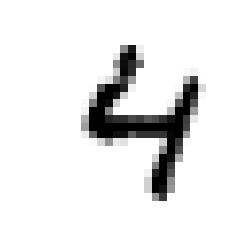

one-hot vecotr: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
4


In [7]:
# Create validation set
X_val = X[val_perm].T / 255 # normalize
print("X_val shape:",np.shape(X_val))

digits = 10
examples = val_perm.shape[0]

y_val = y[val_perm]
print("y_val shape before one-hot code:",np.shape(y_val))
y_val = y_val.reshape(1, examples)
y_val = np.eye(digits)[y_val.astype('int32')]
y_val = y_val.T.reshape(digits, examples)
print("y_val shape after one-hot code:",np.shape(y_val))

# show an image
i = 65
plt.imshow(X_val[:,i].reshape(28,28), cmap = plt.cm.binary)
plt.axis("off")
plt.show()
print("one-hot vecotr:",y_val[:,i])
print(y[val_perm][i])

X_test shape: (784, 7000)
y_test shape before one-hot code: (7000,)
y_test shape after one-hot code: (10, 7000)


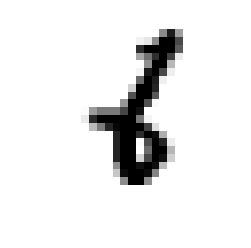

one-hot vector: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
6


In [8]:
# Create test set
X_test = X[test_perm].T / 255 # normalize
print("X_test shape:",np.shape(X_test))

digits = 10
examples = test_perm.shape[0]

y_test = y[test_perm]
print("y_test shape before one-hot code:",np.shape(y_test))
y_test = y_test.reshape(1, examples)
y_test = np.eye(digits)[y_test.astype('int32')]
y_test = y_test.T.reshape(digits, examples)
print("y_test shape after one-hot code:",np.shape(y_test))

# show an image
i = 65
plt.imshow(X_test[:,i].reshape(28,28), cmap = plt.cm.binary)
plt.axis("off")
plt.show()
print("one-hot vector:",y_test[:,i])
print(y[test_perm][i])

Visualize a random sampling of the digits.

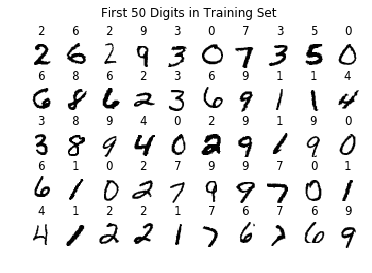

In [9]:
# Show the a number of digits from the train set
r=5 # rows in plot
c=10 # columns in plot

# Plot a random sample

fig, axes = plt.subplots(r, c,)
fig.suptitle('First %i Digits in Training Set' %(r*c))

index = 0
for i in range(0,r):
    for t in range(0,c):
        axes[i][t].imshow(X_train[:,index].reshape(28,28), cmap = plt.cm.binary)
        axes[i][t].axis('off')
        axes[i][t].set_title(y[train_perm][index])
        index += 1
    
plt.show()

## Question 3

Now we are going to train our neural network on the MNIST data.

Training...
Epoch 0 	  Train cost: 5.7472853 	Val cost: 4.3112646
Epoch 2000 	  Train cost: 0.2442306 	Val cost: 0.2782297
Epoch 4000 	  Train cost: 0.1792935 	Val cost: 0.2307895
Epoch 6000 	  Train cost: 0.1446740 	Val cost: 0.2085004
Epoch 8000 	  Train cost: 0.1216501 	Val cost: 0.1969495
Epoch 10000 	  Train cost: 0.1048090 	Val cost: 0.1912129
Epoch 12000 	  Train cost: 0.0914635 	Val cost: 0.1878119
Epoch 14000 	  Train cost: 0.0806873 	Val cost: 0.1854423
Epoch 16000 	  Train cost: 0.0717835 	Val cost: 0.1840456
Epoch 18000 	  Train cost: 0.0642526 	Val cost: 0.1835660
Epoch 19999 	  Train cost: 0.0578342
Training finished


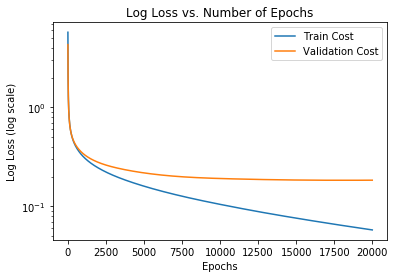


Confusion Matrix:
[[675   0   2   0   1   5   6   1   6   1]
 [  0 786   1   2   3   2   4   4   8   1]
 [  5   3 638  12   2   2   5   8   5   2]
 [  1   2   5 718   1  18   0   3   6   2]
 [  0   1   3   0 667   3   3   2   3  19]
 [  1   1   1  17   2 534   6   0   9   3]
 [  3   0   3   3   4   7 686   0   5   1]
 [  2   1   7   7   2   2   1 716   2  10]
 [  1   1  10  10   1   5   5   1 606   2]
 [  2   0   1   3  23   5   0  10   4 627]]

Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       697
           1       0.99      0.97      0.98       811
           2       0.95      0.94      0.94       682
           3       0.93      0.95      0.94       756
           4       0.94      0.95      0.95       701
           5       0.92      0.93      0.92       574
           6       0.96      0.96      0.96       712
           7       0.96      0.95      0.96       750
           8       0.93      0.94     

In [10]:
# Set seed so that results can be replicated
np.random.seed(seed=8)

# Train and validate
nn2 = Network(X=X_train, y=y_train, X_val=X_val, y_val=y_val, h_size=64,class_size=10)
nn2.train(learn_rate=0.9, epochs=20000)
nn2.loss_chart().show()
nn2.predict(X=X_val,y=y_val)

Training took a long time. It seems very difficult to get the validation cost (validation log loss) to increase even after a long time in training. I believe this is because the examples in the validation data are too close to the examples in the training data.

Now let's see how the network learned by looking at the test set.

In [11]:
nn2.predict(X=X_test,y=y_test)


Confusion Matrix:
[[679   0   2   2   0   3   5   3   4   1]
 [  0 753   1   5   1   2   0   4   5   0]
 [  0   2 672  14   1   4   2   7   6   0]
 [  3   3   7 638   1  14   0   3   7   3]
 [  1   1  11   2 604   3   1   4   4  14]
 [  9   1   0  17   0 613   7   5  20   3]
 [  5   1   3   2   3   5 681   0   2   2]
 [  2   3   4   7   3   0   1 690   3  10]
 [  2   3   6   5   5  10   2   1 662   5]
 [  3   1   3   6  15   7   0   7   8 645]]

Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       699
           1       0.98      0.98      0.98       771
           2       0.95      0.95      0.95       708
           3       0.91      0.94      0.93       679
           4       0.95      0.94      0.95       645
           5       0.93      0.91      0.92       675
           6       0.97      0.97      0.97       704
           7       0.95      0.95      0.95       723
           8       0.92      0.94     

Looks like the network performs well! We get 95% precision. However, I still wonder if we are "overfitting" to the data.

## Question 4

When we use sigmoidal activation functions for the outpus utits and sum of squared error for the cost -- when compared to using softmax axtivation and negative log likelihood cost -- we are more likely to have a situation where we do not get good convergence and slow learning. This is becuase the MSE cost function is non-convex in nature. As such, it could have large absolute values, causing the sigmoid activation function to saturate.

## Question 5

If we use a single linear output unit, trained on the actual class number using sum squared error cost, I would expect that the training would be difficult. This is because a linear activation can go from negative infinity to positive infinity. Furthermore, squared error is not a convex function and may prove problematic.